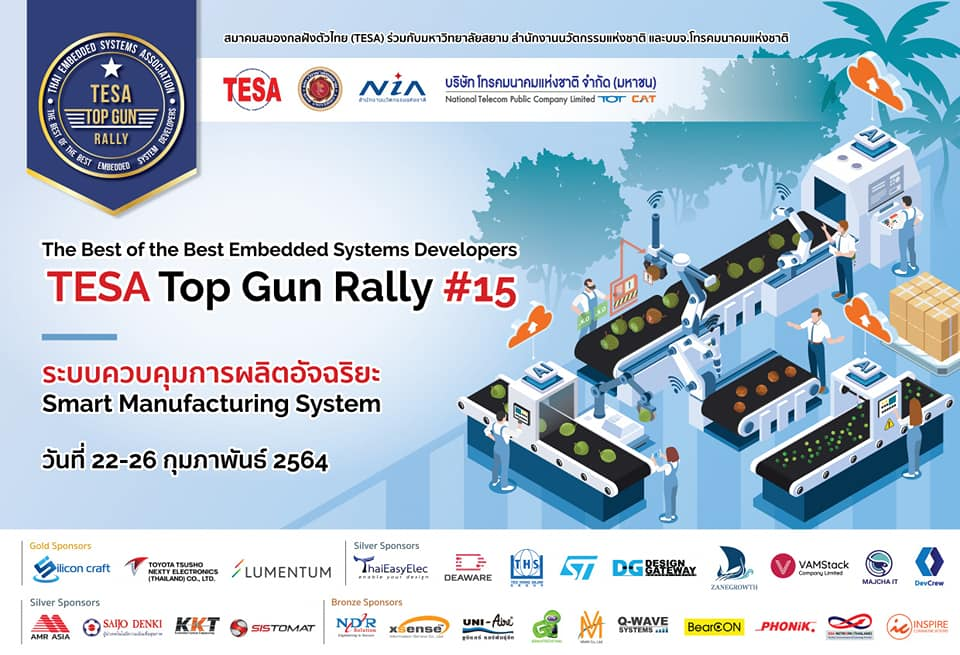

# Step 1: prepare dataset (offline)

## 1.1 Get video files

## 1.2 Prepare images using OpenCV

## 1.3 Prepare labelImg
1. install required packages: `pip install PyQt5 lxml`
1. clone labelImg repository: `git clone https://github.com/tzutalin/labelImg`
1. move into folder: `cd labelImg`
1. build labelImg: `pyrcc5 -o libs/resources.py resources.qrc`
1. run labelImg: `python labelImg.py`
1. click **Open Dir** and set **Save Dir**
1. use 'a' to previous, 'd' to next, 'w' to start rect

## 1.4 upload to Google Drive
* **data/train/** folder for image and xml files
* **data/test/** folder for image and xml files
* **data/annotations.json** for class definition

# Step 2: prepare dataset

## 2.1 mount Google Drive

In [ ]:

#2.1 Mount Google Drive
from google.colab import drive
import os

drive.mount('/content/drive')
try:
  os.mkdir('/content/drive/My Drive/TGR09-ML-DAY2')  
  os.chdir('/content/drive/My Drive/TGR09-ML-DAY2')
except:
  os.chdir('/content/drive/My Drive/TGR09-ML-DAY2')

# folders and files definition
train_images_folder = 'data/train/'
test_images_folder = 'data/test/'
annotation_file = 'data/annotations.json'

Mounted at /content/drive


## 2.2 convert data files

In [ ]:
#2.2 convert data files
import cv2
import json
import glob
import numpy as np
import xml.etree.ElementTree as ET
import tensorflow as tf
from six import BytesIO
from PIL import Image

def load_image_into_numpy_array(img_file):
  return cv2.imread(img_file)

# import class definition from JSON
with open(annotation_file) as f:
  classes_dict = json.load(f)
  num_classes = len(classes_dict)
  
train_images_np = []
classes_np = []
gt_boxes = []
for img_file in glob.glob(train_images_folder + '*.jpg'):
  # import image as numpy array
  train_images_np.append( load_image_into_numpy_array(img_file) )
  # import XML as numpy array
  xml_file = img_file.replace('.jpg', '.xml')
  tree = ET.parse(xml_file)
  root = tree.getroot()
  width = int(root.find('size')[0].text)
  height = int(root.find('size')[1].text)
  classes = []
  bbox = []
  for member in root.findall('object'):
    classes.append(classes_dict[member[0].text] - 1)
    bbox.append([
        float(member[4][1].text)/height,
        float(member[4][0].text)/width,
        float(member[4][3].text)/height,
        float(member[4][2].text)/width
    ])
  classes_np.append(np.array(classes, dtype=np.int32))
  gt_boxes.append(np.array(bbox, dtype=np.float32))

In [ ]:
classes_np

[array([1], dtype=int32),
 array([1], dtype=int32),
 array([1], dtype=int32),
 array([1], dtype=int32),
 array([1], dtype=int32),
 array([1], dtype=int32),
 array([1], dtype=int32),
 array([1], dtype=int32),
 array([0], dtype=int32),
 array([0], dtype=int32),
 array([0], dtype=int32),
 array([0], dtype=int32),
 array([0], dtype=int32),
 array([0], dtype=int32),
 array([0], dtype=int32),
 array([0], dtype=int32),
 array([0], dtype=int32),
 array([0], dtype=int32),
 array([0], dtype=int32),
 array([0], dtype=int32),
 array([0], dtype=int32),
 array([0], dtype=int32),
 array([0], dtype=int32),
 array([0], dtype=int32),
 array([0], dtype=int32),
 array([0], dtype=int32),
 array([0], dtype=int32),
 array([0], dtype=int32),
 array([0], dtype=int32),
 array([0], dtype=int32),
 array([0], dtype=int32),
 array([0], dtype=int32),
 array([0], dtype=int32),
 array([0], dtype=int32),
 array([0], dtype=int32),
 array([0], dtype=int32),
 array([0], dtype=int32),
 array([0], dtype=int32),
 array([0], 

In [ ]:
# convery list of numpy arrays to tensor
num_classes = len(classes_dict)
train_image_tensors = []
gt_box_tensors = []
gt_classes_one_hot_tensors = []
for (train_image_np, gt_box_np, class_np) in zip(train_images_np, gt_boxes, classes_np):
  train_image_tensors.append(tf.expand_dims(tf.convert_to_tensor(train_image_np, dtype=tf.float32), axis=0))
  gt_box_tensors.append(tf.convert_to_tensor(gt_box_np, dtype=tf.float32))
  zero_indexed_groundtruth_classes = tf.convert_to_tensor(class_np)
  gt_classes_one_hot_tensors.append(tf.one_hot(zero_indexed_groundtruth_classes, num_classes))
print('Done prepping data.')

Done prepping data.


In [ ]:
gt_classes_one_hot_tensors

[<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0., 1.]], dtype=float32)>,
 <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0., 1.]], dtype=float32)>,
 <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0., 1.]], dtype=float32)>,
 <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0., 1.]], dtype=float32)>,
 <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0., 1.]], dtype=float32)>,
 <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0., 1.]], dtype=float32)>,
 <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0., 1.]], dtype=float32)>,
 <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0., 1.]], dtype=float32)>,
 <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[1., 0.]], dtype=float32)>,
 <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[1., 0.]], dtype=float32)>,
 <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[1., 0.]], dtype=float32)>,
 <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[1., 0.]], dtype=float32)>,
 <tf

# Step 3: train model

## 3.1 prepare TensorFlow Object Detection API

In [ ]:
#3.1 prepare TensorFlow Object Detection API
import pathlib

if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

Cloning into 'models'...
remote: Enumerating objects: 2428, done.
remote: Counting objects: 100% (2428/2428), done.
remote: Compressing objects: 100% (2024/2024), done.
remote: Total 2428 (delta 582), reused 1380 (delta 376), pack-reused 0
Receiving objects: 100% (2428/2428), 30.80 MiB | 18.10 MiB/s, done.
Resolving deltas: 100% (582/582), done.
Checking out files: 100% (2263/2263), done.


In [ ]:
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

Processing /content/drive/My Drive/TGR09-ML-DAY2/models/research
  Created wheel for object-detection: filename=object_detection-0.1-cp37-none-any.whl size=1619136 sha256=a56543edd94b01104b2d60dfb56570c5cad39e9c170d2a1603267a596ea1c702
  Stored in directory: /tmp/pip-ephem-wheel-cache-k_13ayul/wheels/7b/9c/cc/cb25db0fe937308b99e7d462761f550453e00536968c1d0024
Successfully built object-detection
  Found existing installation: object-detection 0.1
    Uninstalling object-detection-0.1:
      Successfully uninstalled object-detection-0.1


## 3.2 download and prepare model

In [ ]:
# 3.2 download and prepare model
!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz
!tar -xf ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz
!mv ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint models/research/object_detection/test_data/

--2021-02-24 02:54:38--  http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 172.253.63.128, 2607:f8b0:4004:c08::80
Connecting to download.tensorflow.org (download.tensorflow.org)|172.253.63.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20515344 (20M) [application/x-tar]
Saving to: ‘ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz.3’

ssd_mobilenet_v2_fp 100%[===================>]  19.56M  82.7MB/s    in 0.2s    

2021-02-24 02:54:39 (82.7 MB/s) - ‘ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz.3’ saved [20515344/20515344]



In [ ]:
# import libraries
import matplotlib
import matplotlib.pyplot as plt
import random

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import colab_utils
from object_detection.builders import model_builder

%matplotlib inline

# model definition
model_dim = 320

[[0.57375 0.7125  0.75875 0.9175 ]]
0


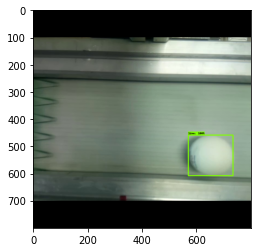

In [ ]:
category_index = {1: {'id': 1, 'name': 'lime'}, 2: {'id': 2, 'name': 'marker'},}
dummy_scores = np.array([1],dtype=np.float32)

def plot_detections(image_np,
                    boxes,
                    classes,
                    scores,
                    category_index,
                    figsize=(12, 16),
                    image_name=None):
  image_np_with_annotations = cv2.cvtColor(image_np.copy(), cv2.COLOR_BGR2RGB)
  viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_annotations,
      boxes,
      classes,
      scores,
      category_index,
      use_normalized_coordinates=True,
      min_score_thresh=0.8)
  if image_name:
    plt.imsave(image_name, image_np_with_annotations)
  else:
    plt.imshow(image_np_with_annotations)

idx = 0
print(gt_boxes[idx])
print(class_np[idx])
plot_detections(
    train_images_np[idx],
    gt_boxes[idx],
    np.ones(shape=[gt_boxes[idx].shape[0]], dtype=np.int32),
    dummy_scores, 
    category_index)

## 3.3 train model

In [ ]:
tf.keras.backend.clear_session()

print('Building model and restoring weights for fine-tuning...', flush=True)
pipeline_config = 'models/research/object_detection/configs/tf2/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.config'
checkpoint_path = 'models/research/object_detection/test_data/checkpoint/ckpt-0'

# Load pipeline config and build a detection model.
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
model_config.ssd.num_classes = num_classes
model_config.ssd.post_processing.batch_non_max_suppression.max_detections_per_class = 10
model_config.ssd.post_processing.batch_non_max_suppression.max_total_detections = 10
model_config.ssd.freeze_batchnorm = True
detection_model = model_builder.build(model_config=model_config, is_training=True)

# Set up object-based checkpoint restore
fake_box_predictor = tf.compat.v2.train.Checkpoint(
    _base_tower_layers_for_heads=detection_model._box_predictor._base_tower_layers_for_heads,
    #_prediction_heads=detection_model._box_predictor._prediction_heads,
    #    (i.e., the classification head that we *will not* restore)
    _box_prediction_head=detection_model._box_predictor._box_prediction_head,
    )
fake_model = tf.compat.v2.train.Checkpoint(
          _feature_extractor=detection_model._feature_extractor,
          _box_predictor=fake_box_predictor)
ckpt = tf.compat.v2.train.Checkpoint(model=fake_model)
ckpt.restore(checkpoint_path).expect_partial()

# Run model through a dummy image so that variables are created
image, shapes = detection_model.preprocess(tf.zeros([1, model_dim, model_dim, 3]))
prediction_dict = detection_model.predict(image, shapes)
_ = detection_model.postprocess(prediction_dict, shapes)
print('Weights restored!')

Building model and restoring weights for fine-tuning...
Weights restored!


In [ ]:
# 3.3 train model
tf.keras.backend.set_learning_phase(True)

# These parameters can be tuned
batch_size = 5
learning_rate = 0.15
num_batches = 200

# Select variables in top layers to fine-tune.
trainable_variables = detection_model.trainable_variables
to_fine_tune = []
prefixes_to_train = [
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead',
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead']
for var in trainable_variables:
  if any([var.name.startswith(prefix) for prefix in prefixes_to_train]):
    to_fine_tune.append(var)

# Set up forward + backward pass for a single train step.
def get_model_train_step_function(model, optimizer, vars_to_fine_tune):
  """Get a tf.function for training step."""

  # Use tf.function for a bit of speed.
  @tf.function
  def train_step_fn(image_tensors,
                    groundtruth_boxes_list,
                    groundtruth_classes_list):
    shapes = tf.constant(batch_size * [[model_dim, model_dim, 3]], dtype=tf.int32)
    model.provide_groundtruth(
        groundtruth_boxes_list=groundtruth_boxes_list,
        groundtruth_classes_list=groundtruth_classes_list)
    with tf.GradientTape() as tape:
      preprocessed_images = tf.concat(
          [detection_model.preprocess(image_tensor)[0]
           for image_tensor in image_tensors], axis=0)
      prediction_dict = model.predict(preprocessed_images, shapes)
      losses_dict = model.loss(prediction_dict, shapes)
      total_loss = losses_dict['Loss/localization_loss'] + losses_dict['Loss/classification_loss']
      gradients = tape.gradient(total_loss, vars_to_fine_tune)
      optimizer.apply_gradients(zip(gradients, vars_to_fine_tune))
    return total_loss

  return train_step_fn

optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
train_step_fn = get_model_train_step_function(
    detection_model, optimizer, to_fine_tune)

print('Start fine-tuning!', flush=True)
for idx in range(num_batches):
  # Grab keys for a random subset of examples
  all_keys = list(range(len(train_images_np)))
  random.shuffle(all_keys)
  example_keys = all_keys[:batch_size]

  gt_boxes_list = [gt_box_tensors[key] for key in example_keys]
  gt_classes_list = [gt_classes_one_hot_tensors[key] for key in example_keys]
  image_tensors = [train_image_tensors[key] for key in example_keys]

  # Training step (forward pass + backwards pass)
  total_loss = train_step_fn(image_tensors, gt_boxes_list, gt_classes_list)

  if idx % 5 == 0:
    print('batch ' + str(idx) + ' of ' + str(num_batches)
    + ', loss=' +  str(total_loss.numpy()), flush=True)

print('Done fine-tuning!')

Start fine-tuning!


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:434: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


batch 0 of 200, loss=0.10689195
batch 5 of 200, loss=0.09751047
batch 10 of 200, loss=0.08848716
batch 15 of 200, loss=0.09806523
batch 20 of 200, loss=0.1051172
batch 25 of 200, loss=0.049407437
batch 30 of 200, loss=0.07818233
batch 35 of 200, loss=0.10119425
batch 40 of 200, loss=0.092455804
batch 45 of 200, loss=0.07692972
batch 50 of 200, loss=0.078323245
batch 55 of 200, loss=0.085274525
batch 60 of 200, loss=0.073547594
batch 65 of 200, loss=0.052052993
batch 70 of 200, loss=0.08046947
batch 75 of 200, loss=0.13600366
batch 80 of 200, loss=0.101328224
batch 85 of 200, loss=0.08962575
batch 90 of 200, loss=0.07961091
batch 95 of 200, loss=0.086217225
batch 100 of 200, loss=0.09685386
batch 105 of 200, loss=0.07947536
batch 110 of 200, loss=0.07988828
batch 115 of 200, loss=0.12559335
batch 120 of 200, loss=0.070519544
batch 125 of 200, loss=0.083370194
batch 130 of 200, loss=0.060759746
batch 135 of 200, loss=0.07904743
batch 140 of 200, loss=0.09735812
batch 145 of 200, loss=0.0

## 3.4 preview result

[] []
[2] [[0.5299058 0.3473858 0.7060001 0.5305271]]
[2] [[0.51893467 0.7263597  0.69951767 0.92539227]]
[2] [[0.40318632 0.2737147  0.57962143 0.4610887 ]]
[2] [[0.3670357  0.74094486 0.5447518  0.93990755]]
[2] [[0.4231461  0.43799272 0.60137844 0.628971  ]]
[2] [[0.4831951  0.22358124 0.6594354  0.4213009 ]]
[1] [[0.3975848  0.58393395 0.5829549  0.77448237]]
[1] [[0.5086742 0.5492583 0.6991531 0.7441023]]
[1] [[0.38152573 0.70112693 0.5782318  0.915426  ]]
[1] [[0.44658643 0.4249363  0.633588   0.62343335]]
[1] [[0.5064561  0.6116955  0.7080124  0.82796335]]
[1] [[0.43678305 0.5539368  0.6281109  0.75764877]]
[1] [[0.40003854 0.6993356  0.5953099  0.9117279 ]]
[1] [[0.4397542  0.59696704 0.6295362  0.797803  ]]
[1] [[0.44822252 0.5989558  0.6479473  0.7998969 ]]
[1] [[0.5005861 0.5807879 0.6974017 0.786989 ]]
[1] [[0.44272646 0.547985   0.6329873  0.7420749 ]]
[1] [[0.44769594 0.5450876  0.6447879  0.74719346]]
[1] [[0.41539034 0.5294601  0.6018568  0.72960114]]
[1] [[0.4634596  0

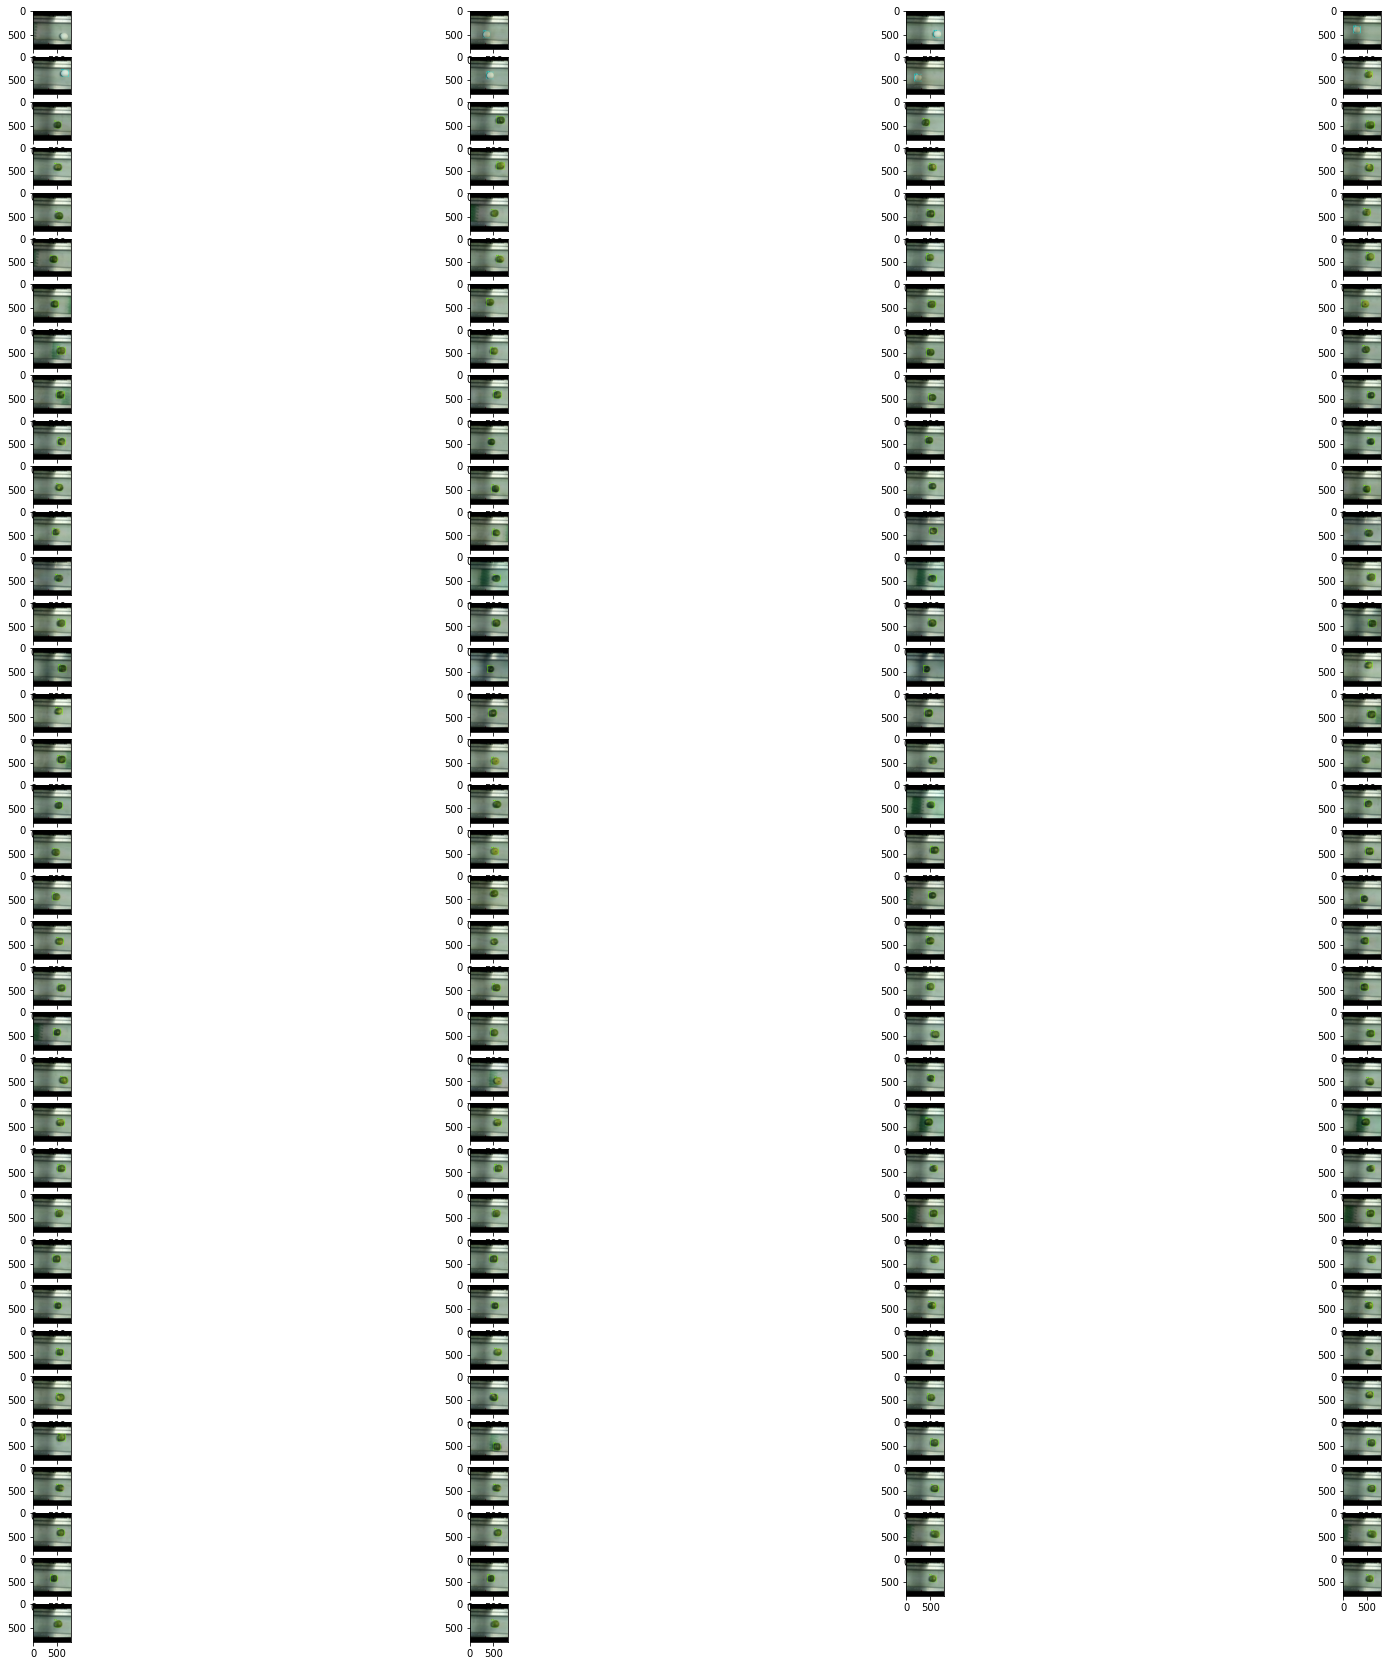

In [ ]:
# 3.4 preview
category_index = {1: {'id': 1, 'name': 'lime'}, 2: {'id': 2, 'name': 'marker'},}

@tf.function
def detect(input_tensor):
  preprocessed_image, shapes = detection_model.preprocess(input_tensor)
  prediction_dict = detection_model.predict(preprocessed_image, shapes)
  return detection_model.postprocess(prediction_dict, shapes)

test_images_np = []
for img_file in glob.glob(test_images_folder + '*.jpg'):
  test_images_np.append(np.expand_dims(
      load_image_into_numpy_array(img_file), axis=0))

plt.figure(figsize=(30, 30))
for idx in range(len(test_images_np)):
  plt.subplot(len(test_images_np)//4+1, 4, idx+1)
  input_tensor = tf.convert_to_tensor(test_images_np[idx], dtype=tf.float32)
  detections = detect(input_tensor)
  plot_detections(
      test_images_np[idx][0],
      detections['detection_boxes'][0].numpy(),
      detections['detection_classes'][0].numpy().astype(np.uint32) + 1,
      detections['detection_scores'][0].numpy(),
      category_index)
  bboxes = detections['detection_boxes'][0].numpy()
  classes = detections['detection_classes'][0].numpy().astype(np.uint32) + 1
  scores = detections['detection_scores'][0].numpy()
  print(classes[scores > 0.8], bboxes[scores > 0.8])

In [ ]:
bboxes

array([[0.4274979 , 0.5534235 , 0.62161005, 0.76397586],
       [0.06996679, 0.0982438 , 0.871356  , 1.        ],
       [0.44910634, 0.5779626 , 0.51035535, 0.7066073 ],
       [0.42914796, 0.55646646, 0.6211623 , 0.76510763],
       [0.41292965, 0.5897685 , 0.62283003, 0.8497404 ],
       [0.33563215, 0.        , 1.        , 0.8930085 ],
       [0.8298043 , 0.39170337, 0.87114704, 0.4445449 ],
       [0.48144078, 0.884755  , 0.641966  , 1.        ],
       [0.7900658 , 0.32417947, 0.88284296, 0.46743655],
       [0.50096893, 0.8287705 , 0.66745853, 0.99701166]], dtype=float32)

In [ ]:
scores

array([0.99299943, 0.17615761, 0.05573053, 0.05217271, 0.04759159,
       0.04169314, 0.03089685, 0.02953433, 0.02951564, 0.02946022],
      dtype=float32)

# Step 4: export model

In [ ]:
# Save new pipeline config
output_pipeline_path = 'output/'
pipeline_proto = config_util.create_pipeline_proto_from_configs(configs)
config_util.save_pipeline_config(pipeline_proto, output_pipeline_path)

# export checkpoint
output_checkpoint_path = 'output/checkpoints/'
exported_ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt_manager = tf.train.CheckpointManager(
    exported_ckpt, output_checkpoint_path, max_to_keep=1)
ckpt_manager.save()

INFO:tensorflow:Writing pipeline config file to output/pipeline.config


INFO:tensorflow:Writing pipeline config file to output/pipeline.config


'output/checkpoints/ckpt-1'

In [ ]:
tf.saved_model.save(detection_model,"/content/drive/My Drive/TGR09-ML-DAY2/limemodel")

INFO:tensorflow:Unsupported signature for serialization: (([(<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbae0a7f250>, TensorSpec(shape=(None, 40, 40, 32), dtype=tf.float32, name='image_features/0/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbae0a7f750>, TensorSpec(shape=(None, 20, 20, 96), dtype=tf.float32, name='image_features/1/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbae0a7fa10>, TensorSpec(shape=(None, 10, 10, 1280), dtype=tf.float32, name='image_features/2/1'))], False), {}).


INFO:tensorflow:Unsupported signature for serialization: (([(<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbae0a7f250>, TensorSpec(shape=(None, 40, 40, 32), dtype=tf.float32, name='image_features/0/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbae0a7f750>, TensorSpec(shape=(None, 20, 20, 96), dtype=tf.float32, name='image_features/1/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbae0a7fa10>, TensorSpec(shape=(None, 10, 10, 1280), dtype=tf.float32, name='image_features/2/1'))], False), {}).


INFO:tensorflow:Unsupported signature for serialization: (([(<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbae0ae9810>, TensorSpec(shape=(None, 40, 40, 32), dtype=tf.float32, name='image_features/0/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbae0ae9d10>, TensorSpec(shape=(None, 20, 20, 96), dtype=tf.float32, name='image_features/1/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbae0ae9fd0>, TensorSpec(shape=(None, 10, 10, 1280), dtype=tf.float32, name='image_features/2/1'))], True), {}).


INFO:tensorflow:Unsupported signature for serialization: (([(<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbae0ae9810>, TensorSpec(shape=(None, 40, 40, 32), dtype=tf.float32, name='image_features/0/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbae0ae9d10>, TensorSpec(shape=(None, 20, 20, 96), dtype=tf.float32, name='image_features/1/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbae0ae9fd0>, TensorSpec(shape=(None, 10, 10, 1280), dtype=tf.float32, name='image_features/2/1'))], True), {}).


INFO:tensorflow:Unsupported signature for serialization: (([(<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbae0b25490>, TensorSpec(shape=(None, 40, 40, 32), dtype=tf.float32, name='image_features/0/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbae0b25990>, TensorSpec(shape=(None, 20, 20, 96), dtype=tf.float32, name='image_features/1/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbae0b25c50>, TensorSpec(shape=(None, 10, 10, 1280), dtype=tf.float32, name='image_features/2/1'))], False), {}).


INFO:tensorflow:Unsupported signature for serialization: (([(<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbae0b25490>, TensorSpec(shape=(None, 40, 40, 32), dtype=tf.float32, name='image_features/0/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbae0b25990>, TensorSpec(shape=(None, 20, 20, 96), dtype=tf.float32, name='image_features/1/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbae0b25c50>, TensorSpec(shape=(None, 10, 10, 1280), dtype=tf.float32, name='image_features/2/1'))], False), {}).


INFO:tensorflow:Unsupported signature for serialization: (([(<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbae0b76ed0>, TensorSpec(shape=(None, 40, 40, 32), dtype=tf.float32, name='image_features/0/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbae0b72390>, TensorSpec(shape=(None, 20, 20, 96), dtype=tf.float32, name='image_features/1/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbae0b72650>, TensorSpec(shape=(None, 10, 10, 1280), dtype=tf.float32, name='image_features/2/1'))], True), {}).


INFO:tensorflow:Unsupported signature for serialization: (([(<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbae0b76ed0>, TensorSpec(shape=(None, 40, 40, 32), dtype=tf.float32, name='image_features/0/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbae0b72390>, TensorSpec(shape=(None, 20, 20, 96), dtype=tf.float32, name='image_features/1/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbae0b72650>, TensorSpec(shape=(None, 10, 10, 1280), dtype=tf.float32, name='image_features/2/1'))], True), {}).


INFO:tensorflow:Unsupported signature for serialization: (([(<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbae0a7f250>, TensorSpec(shape=(None, 40, 40, 32), dtype=tf.float32, name='image_features/0/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbae0a7f750>, TensorSpec(shape=(None, 20, 20, 96), dtype=tf.float32, name='image_features/1/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbae0a7fa10>, TensorSpec(shape=(None, 10, 10, 1280), dtype=tf.float32, name='image_features/2/1'))], False), {}).


INFO:tensorflow:Unsupported signature for serialization: (([(<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbae0a7f250>, TensorSpec(shape=(None, 40, 40, 32), dtype=tf.float32, name='image_features/0/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbae0a7f750>, TensorSpec(shape=(None, 20, 20, 96), dtype=tf.float32, name='image_features/1/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbae0a7fa10>, TensorSpec(shape=(None, 10, 10, 1280), dtype=tf.float32, name='image_features/2/1'))], False), {}).


INFO:tensorflow:Unsupported signature for serialization: (([(<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbae0ae9810>, TensorSpec(shape=(None, 40, 40, 32), dtype=tf.float32, name='image_features/0/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbae0ae9d10>, TensorSpec(shape=(None, 20, 20, 96), dtype=tf.float32, name='image_features/1/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbae0ae9fd0>, TensorSpec(shape=(None, 10, 10, 1280), dtype=tf.float32, name='image_features/2/1'))], True), {}).


INFO:tensorflow:Unsupported signature for serialization: (([(<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbae0ae9810>, TensorSpec(shape=(None, 40, 40, 32), dtype=tf.float32, name='image_features/0/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbae0ae9d10>, TensorSpec(shape=(None, 20, 20, 96), dtype=tf.float32, name='image_features/1/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbae0ae9fd0>, TensorSpec(shape=(None, 10, 10, 1280), dtype=tf.float32, name='image_features/2/1'))], True), {}).


INFO:tensorflow:Unsupported signature for serialization: (([(<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbae0b25490>, TensorSpec(shape=(None, 40, 40, 32), dtype=tf.float32, name='image_features/0/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbae0b25990>, TensorSpec(shape=(None, 20, 20, 96), dtype=tf.float32, name='image_features/1/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbae0b25c50>, TensorSpec(shape=(None, 10, 10, 1280), dtype=tf.float32, name='image_features/2/1'))], False), {}).


INFO:tensorflow:Unsupported signature for serialization: (([(<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbae0b25490>, TensorSpec(shape=(None, 40, 40, 32), dtype=tf.float32, name='image_features/0/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbae0b25990>, TensorSpec(shape=(None, 20, 20, 96), dtype=tf.float32, name='image_features/1/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbae0b25c50>, TensorSpec(shape=(None, 10, 10, 1280), dtype=tf.float32, name='image_features/2/1'))], False), {}).


INFO:tensorflow:Unsupported signature for serialization: (([(<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbae0b76ed0>, TensorSpec(shape=(None, 40, 40, 32), dtype=tf.float32, name='image_features/0/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbae0b72390>, TensorSpec(shape=(None, 20, 20, 96), dtype=tf.float32, name='image_features/1/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbae0b72650>, TensorSpec(shape=(None, 10, 10, 1280), dtype=tf.float32, name='image_features/2/1'))], True), {}).


INFO:tensorflow:Unsupported signature for serialization: (([(<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbae0b76ed0>, TensorSpec(shape=(None, 40, 40, 32), dtype=tf.float32, name='image_features/0/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbae0b72390>, TensorSpec(shape=(None, 20, 20, 96), dtype=tf.float32, name='image_features/1/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbae0b72650>, TensorSpec(shape=(None, 10, 10, 1280), dtype=tf.float32, name='image_features/2/1'))], True), {}).


INFO:tensorflow:Unsupported signature for serialization: (([(<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbae0b25490>, TensorSpec(shape=(None, 40, 40, 32), dtype=tf.float32, name='image_features/0/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbae0b25990>, TensorSpec(shape=(None, 20, 20, 96), dtype=tf.float32, name='image_features/1/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbae0b25c50>, TensorSpec(shape=(None, 10, 10, 1280), dtype=tf.float32, name='image_features/2/1'))], False), {}).


INFO:tensorflow:Unsupported signature for serialization: (([(<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbae0b25490>, TensorSpec(shape=(None, 40, 40, 32), dtype=tf.float32, name='image_features/0/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbae0b25990>, TensorSpec(shape=(None, 20, 20, 96), dtype=tf.float32, name='image_features/1/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbae0b25c50>, TensorSpec(shape=(None, 10, 10, 1280), dtype=tf.float32, name='image_features/2/1'))], False), {}).


INFO:tensorflow:Unsupported signature for serialization: (([(<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbae0b76ed0>, TensorSpec(shape=(None, 40, 40, 32), dtype=tf.float32, name='image_features/0/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbae0b72390>, TensorSpec(shape=(None, 20, 20, 96), dtype=tf.float32, name='image_features/1/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbae0b72650>, TensorSpec(shape=(None, 10, 10, 1280), dtype=tf.float32, name='image_features/2/1'))], True), {}).


INFO:tensorflow:Unsupported signature for serialization: (([(<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbae0b76ed0>, TensorSpec(shape=(None, 40, 40, 32), dtype=tf.float32, name='image_features/0/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbae0b72390>, TensorSpec(shape=(None, 20, 20, 96), dtype=tf.float32, name='image_features/1/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbae0b72650>, TensorSpec(shape=(None, 10, 10, 1280), dtype=tf.float32, name='image_features/2/1'))], True), {}).


INFO:tensorflow:Unsupported signature for serialization: (([(<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbae0a7f250>, TensorSpec(shape=(None, 40, 40, 32), dtype=tf.float32, name='image_features/0/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbae0a7f750>, TensorSpec(shape=(None, 20, 20, 96), dtype=tf.float32, name='image_features/1/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbae0a7fa10>, TensorSpec(shape=(None, 10, 10, 1280), dtype=tf.float32, name='image_features/2/1'))], False), {}).


INFO:tensorflow:Unsupported signature for serialization: (([(<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbae0a7f250>, TensorSpec(shape=(None, 40, 40, 32), dtype=tf.float32, name='image_features/0/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbae0a7f750>, TensorSpec(shape=(None, 20, 20, 96), dtype=tf.float32, name='image_features/1/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbae0a7fa10>, TensorSpec(shape=(None, 10, 10, 1280), dtype=tf.float32, name='image_features/2/1'))], False), {}).


INFO:tensorflow:Unsupported signature for serialization: (([(<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbae0ae9810>, TensorSpec(shape=(None, 40, 40, 32), dtype=tf.float32, name='image_features/0/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbae0ae9d10>, TensorSpec(shape=(None, 20, 20, 96), dtype=tf.float32, name='image_features/1/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbae0ae9fd0>, TensorSpec(shape=(None, 10, 10, 1280), dtype=tf.float32, name='image_features/2/1'))], True), {}).


INFO:tensorflow:Unsupported signature for serialization: (([(<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbae0ae9810>, TensorSpec(shape=(None, 40, 40, 32), dtype=tf.float32, name='image_features/0/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbae0ae9d10>, TensorSpec(shape=(None, 20, 20, 96), dtype=tf.float32, name='image_features/1/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbae0ae9fd0>, TensorSpec(shape=(None, 10, 10, 1280), dtype=tf.float32, name='image_features/2/1'))], True), {}).


INFO:tensorflow:Unsupported signature for serialization: (([(<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbae0b25490>, TensorSpec(shape=(None, 40, 40, 32), dtype=tf.float32, name='image_features/0/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbae0b25990>, TensorSpec(shape=(None, 20, 20, 96), dtype=tf.float32, name='image_features/1/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbae0b25c50>, TensorSpec(shape=(None, 10, 10, 1280), dtype=tf.float32, name='image_features/2/1'))], False), {}).


INFO:tensorflow:Unsupported signature for serialization: (([(<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbae0b25490>, TensorSpec(shape=(None, 40, 40, 32), dtype=tf.float32, name='image_features/0/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbae0b25990>, TensorSpec(shape=(None, 20, 20, 96), dtype=tf.float32, name='image_features/1/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbae0b25c50>, TensorSpec(shape=(None, 10, 10, 1280), dtype=tf.float32, name='image_features/2/1'))], False), {}).


INFO:tensorflow:Unsupported signature for serialization: (([(<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbae0b76ed0>, TensorSpec(shape=(None, 40, 40, 32), dtype=tf.float32, name='image_features/0/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbae0b72390>, TensorSpec(shape=(None, 20, 20, 96), dtype=tf.float32, name='image_features/1/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbae0b72650>, TensorSpec(shape=(None, 10, 10, 1280), dtype=tf.float32, name='image_features/2/1'))], True), {}).


INFO:tensorflow:Unsupported signature for serialization: (([(<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbae0b76ed0>, TensorSpec(shape=(None, 40, 40, 32), dtype=tf.float32, name='image_features/0/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbae0b72390>, TensorSpec(shape=(None, 20, 20, 96), dtype=tf.float32, name='image_features/1/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbae0b72650>, TensorSpec(shape=(None, 10, 10, 1280), dtype=tf.float32, name='image_features/2/1'))], True), {}).


INFO:tensorflow:Unsupported signature for serialization: (([(<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbae0a7f250>, TensorSpec(shape=(None, 40, 40, 32), dtype=tf.float32, name='image_features/0/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbae0a7f750>, TensorSpec(shape=(None, 20, 20, 96), dtype=tf.float32, name='image_features/1/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbae0a7fa10>, TensorSpec(shape=(None, 10, 10, 1280), dtype=tf.float32, name='image_features/2/1'))], False), {}).


INFO:tensorflow:Unsupported signature for serialization: (([(<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbae0a7f250>, TensorSpec(shape=(None, 40, 40, 32), dtype=tf.float32, name='image_features/0/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbae0a7f750>, TensorSpec(shape=(None, 20, 20, 96), dtype=tf.float32, name='image_features/1/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbae0a7fa10>, TensorSpec(shape=(None, 10, 10, 1280), dtype=tf.float32, name='image_features/2/1'))], False), {}).


INFO:tensorflow:Unsupported signature for serialization: (([(<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbae0ae9810>, TensorSpec(shape=(None, 40, 40, 32), dtype=tf.float32, name='image_features/0/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbae0ae9d10>, TensorSpec(shape=(None, 20, 20, 96), dtype=tf.float32, name='image_features/1/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbae0ae9fd0>, TensorSpec(shape=(None, 10, 10, 1280), dtype=tf.float32, name='image_features/2/1'))], True), {}).


INFO:tensorflow:Unsupported signature for serialization: (([(<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbae0ae9810>, TensorSpec(shape=(None, 40, 40, 32), dtype=tf.float32, name='image_features/0/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbae0ae9d10>, TensorSpec(shape=(None, 20, 20, 96), dtype=tf.float32, name='image_features/1/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbae0ae9fd0>, TensorSpec(shape=(None, 10, 10, 1280), dtype=tf.float32, name='image_features/2/1'))], True), {}).


INFO:tensorflow:Unsupported signature for serialization: (([(<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbae0b25490>, TensorSpec(shape=(None, 40, 40, 32), dtype=tf.float32, name='image_features/0/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbae0b25990>, TensorSpec(shape=(None, 20, 20, 96), dtype=tf.float32, name='image_features/1/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbae0b25c50>, TensorSpec(shape=(None, 10, 10, 1280), dtype=tf.float32, name='image_features/2/1'))], False), {}).


INFO:tensorflow:Unsupported signature for serialization: (([(<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbae0b25490>, TensorSpec(shape=(None, 40, 40, 32), dtype=tf.float32, name='image_features/0/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbae0b25990>, TensorSpec(shape=(None, 20, 20, 96), dtype=tf.float32, name='image_features/1/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbae0b25c50>, TensorSpec(shape=(None, 10, 10, 1280), dtype=tf.float32, name='image_features/2/1'))], False), {}).


INFO:tensorflow:Unsupported signature for serialization: (([(<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbae0b76ed0>, TensorSpec(shape=(None, 40, 40, 32), dtype=tf.float32, name='image_features/0/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbae0b72390>, TensorSpec(shape=(None, 20, 20, 96), dtype=tf.float32, name='image_features/1/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbae0b72650>, TensorSpec(shape=(None, 10, 10, 1280), dtype=tf.float32, name='image_features/2/1'))], True), {}).


INFO:tensorflow:Unsupported signature for serialization: (([(<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbae0b76ed0>, TensorSpec(shape=(None, 40, 40, 32), dtype=tf.float32, name='image_features/0/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbae0b72390>, TensorSpec(shape=(None, 20, 20, 96), dtype=tf.float32, name='image_features/1/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbae0b72650>, TensorSpec(shape=(None, 10, 10, 1280), dtype=tf.float32, name='image_features/2/1'))], True), {}).


INFO:tensorflow:Unsupported signature for serialization: (([(<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbae0b25490>, TensorSpec(shape=(None, 40, 40, 32), dtype=tf.float32, name='image_features/0/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbae0b25990>, TensorSpec(shape=(None, 20, 20, 96), dtype=tf.float32, name='image_features/1/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbae0b25c50>, TensorSpec(shape=(None, 10, 10, 1280), dtype=tf.float32, name='image_features/2/1'))], False), {}).


INFO:tensorflow:Unsupported signature for serialization: (([(<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbae0b25490>, TensorSpec(shape=(None, 40, 40, 32), dtype=tf.float32, name='image_features/0/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbae0b25990>, TensorSpec(shape=(None, 20, 20, 96), dtype=tf.float32, name='image_features/1/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbae0b25c50>, TensorSpec(shape=(None, 10, 10, 1280), dtype=tf.float32, name='image_features/2/1'))], False), {}).


INFO:tensorflow:Unsupported signature for serialization: (([(<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbae0b76ed0>, TensorSpec(shape=(None, 40, 40, 32), dtype=tf.float32, name='image_features/0/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbae0b72390>, TensorSpec(shape=(None, 20, 20, 96), dtype=tf.float32, name='image_features/1/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbae0b72650>, TensorSpec(shape=(None, 10, 10, 1280), dtype=tf.float32, name='image_features/2/1'))], True), {}).


INFO:tensorflow:Unsupported signature for serialization: (([(<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbae0b76ed0>, TensorSpec(shape=(None, 40, 40, 32), dtype=tf.float32, name='image_features/0/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbae0b72390>, TensorSpec(shape=(None, 20, 20, 96), dtype=tf.float32, name='image_features/1/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbae0b72650>, TensorSpec(shape=(None, 10, 10, 1280), dtype=tf.float32, name='image_features/2/1'))], True), {}).


INFO:tensorflow:Unsupported signature for serialization: (([(<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbae0a7f250>, TensorSpec(shape=(None, 40, 40, 32), dtype=tf.float32, name='image_features/0/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbae0a7f750>, TensorSpec(shape=(None, 20, 20, 96), dtype=tf.float32, name='image_features/1/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbae0a7fa10>, TensorSpec(shape=(None, 10, 10, 1280), dtype=tf.float32, name='image_features/2/1'))], False), {}).


INFO:tensorflow:Unsupported signature for serialization: (([(<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbae0a7f250>, TensorSpec(shape=(None, 40, 40, 32), dtype=tf.float32, name='image_features/0/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbae0a7f750>, TensorSpec(shape=(None, 20, 20, 96), dtype=tf.float32, name='image_features/1/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbae0a7fa10>, TensorSpec(shape=(None, 10, 10, 1280), dtype=tf.float32, name='image_features/2/1'))], False), {}).


INFO:tensorflow:Unsupported signature for serialization: (([(<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbae0ae9810>, TensorSpec(shape=(None, 40, 40, 32), dtype=tf.float32, name='image_features/0/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbae0ae9d10>, TensorSpec(shape=(None, 20, 20, 96), dtype=tf.float32, name='image_features/1/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbae0ae9fd0>, TensorSpec(shape=(None, 10, 10, 1280), dtype=tf.float32, name='image_features/2/1'))], True), {}).


INFO:tensorflow:Unsupported signature for serialization: (([(<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbae0ae9810>, TensorSpec(shape=(None, 40, 40, 32), dtype=tf.float32, name='image_features/0/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbae0ae9d10>, TensorSpec(shape=(None, 20, 20, 96), dtype=tf.float32, name='image_features/1/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbae0ae9fd0>, TensorSpec(shape=(None, 10, 10, 1280), dtype=tf.float32, name='image_features/2/1'))], True), {}).


INFO:tensorflow:Unsupported signature for serialization: (([(<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbae0b25490>, TensorSpec(shape=(None, 40, 40, 32), dtype=tf.float32, name='image_features/0/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbae0b25990>, TensorSpec(shape=(None, 20, 20, 96), dtype=tf.float32, name='image_features/1/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbae0b25c50>, TensorSpec(shape=(None, 10, 10, 1280), dtype=tf.float32, name='image_features/2/1'))], False), {}).


INFO:tensorflow:Unsupported signature for serialization: (([(<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbae0b25490>, TensorSpec(shape=(None, 40, 40, 32), dtype=tf.float32, name='image_features/0/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbae0b25990>, TensorSpec(shape=(None, 20, 20, 96), dtype=tf.float32, name='image_features/1/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbae0b25c50>, TensorSpec(shape=(None, 10, 10, 1280), dtype=tf.float32, name='image_features/2/1'))], False), {}).


INFO:tensorflow:Unsupported signature for serialization: (([(<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbae0b76ed0>, TensorSpec(shape=(None, 40, 40, 32), dtype=tf.float32, name='image_features/0/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbae0b72390>, TensorSpec(shape=(None, 20, 20, 96), dtype=tf.float32, name='image_features/1/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbae0b72650>, TensorSpec(shape=(None, 10, 10, 1280), dtype=tf.float32, name='image_features/2/1'))], True), {}).


INFO:tensorflow:Unsupported signature for serialization: (([(<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbae0b76ed0>, TensorSpec(shape=(None, 40, 40, 32), dtype=tf.float32, name='image_features/0/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbae0b72390>, TensorSpec(shape=(None, 20, 20, 96), dtype=tf.float32, name='image_features/1/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbae0b72650>, TensorSpec(shape=(None, 10, 10, 1280), dtype=tf.float32, name='image_features/2/1'))], True), {}).


INFO:tensorflow:Assets written to: /content/drive/My Drive/TGR09-ML-DAY2/limemodel/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/TGR09-ML-DAY2/limemodel/assets


In [ ]:
!ln -s "/content/drive/My Drive" /ml

ln: failed to create symbolic link '/ml/My Drive': Input/output error


In [ ]:
!ls /ml/TGR09-ML-DAY2

ส่งงานAssignment
data
lab1_test.csv
lab1_train.csv
limemodel
models
output
ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8
ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz
ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz.1
ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz.2
ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz.3
TFLite_Lime.ipynb
TFLite_model.ipynb
VDO_AI


In [ ]:
!python /ml/TGR09-ML-DAY2/models/research/object_detection/export_tflite_graph_tf2.py --pipeline_config_path /ml/TGR09-ML-DAY2/output/pipeline.config --trained_checkpoint_dir /ml/TGR09-ML-DAY2/output/checkpoints/ --output_directory /ml/TGR09-ML-DAY2/output/

2021-02-24 03:09:46.574917: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2021-02-24 03:09:48.839760: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-02-24 03:09:48.840621: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-02-24 03:09:48.846458: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-02-24 03:09:48.846983: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.75GiB deviceMemoryBandwidth: 298.08GiB/s
2021-02-24 03:09:48.847018: I tensorflow/stream_executor/platform/default/dso_loade

In [ ]:
saved_model_dir = '/ml/TGR09-ML-DAY2/output/saved_model/'
tflite_file = '/ml/TGR09-ML-DAY2/output/detect.tflite'

print("{} -> {}".format(saved_model_dir,tflite_file))

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

open(tflite_file,'wb').write(tflite_model)

interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

/ml/TGR09-ML-DAY2/output/saved_model/ -> /ml/TGR09-ML-DAY2/output/detect.tflite
